[View in Colaboratory](https://colab.research.google.com/github/charleswongzx/machine-learning-01.112/blob/master/HW3/Machine_Learning_01_112_HW3.ipynb)

# 1. Matrix Factorisation

In [25]:
import numpy as np

def matrix_factorization(R, P, Q, K, steps=100000, alpha=0.0002, beta=0.02):
  Q = Q.T
  for step in range(steps):
    for i in range(len(R)):
      for j in range(len(R[i])):
        if R[i][j] > -1: # Skip loss compute for missing values 
          eij = R[i][j] - np.dot(P[i,:],Q[:,j])
          for k in range(K):
            P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
            Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
    eR = np.dot(P,Q)
    e = 0
    for i in range(len(R)):
      for j in range(len(R[i])):
        if R[i][j] > -1: # Skip loss compute for missing values 
          e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
          for k in range(K):
            e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )

  return P, Q.T

# Incomplete entries are denoted by -1's
R = np.array([[0,1,-1],
              [1,-1,1],
              [-1,1,2]])

N = len(R)
M = len(R[0])
K = 1

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

U, V = matrix_factorization(R, P, Q, K)

print ('Part A: [A]\n{}'.format(np.dot(U,V.T)))
print ('Part B: [U]\n{}'.format(U))
print ('Part C: [V]\n{}'.format(V))

Part A: [A]
[[0.47940034 0.60332552 0.94402665]
 [0.60352458 0.75953594 1.18844992]
 [0.94437244 1.18849311 1.85964148]]
Part B: [U]
[[0.69116667]
 [0.87012053]
 [1.3615317 ]]
Part C: [V]
[[0.69361032]
 [0.87290888]
 [1.36584516]]


# 2. Support Vector Machines

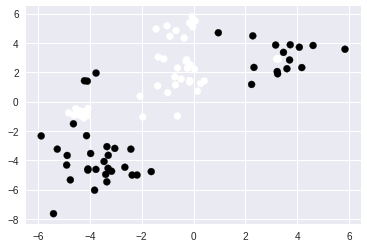

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
csv = 'https://www.dropbox.com/s/wt45tvn9ig3o7vu/kernel.csv?dl=1'
data = np.genfromtxt(csv,delimiter=',')
X = data[:,1:]
Y = data[:,0]
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()



**
(a) Use the sklearn.svm.SVC module in the Python scikit-learn package to train a
kernel support vector machine via the radial basis kernel. Remember to set gamma
to 0.5 and kernel to rbf when initializing the object**

In [0]:
from sklearn.svm import SVC

clf = SVC(gamma=0.5, kernel='rbf').fit(X, Y)

**
(b) Evaluate the kernel SVM’s decision function. You may use the decision function
method in sklearn.svm.SVC. You should write a function that takes coordinates
x1, x2 of a point x ∈ R
2 and the trained sklearn.svm.SVC object clf, and return
the R-valued output of the decision function.**

In [0]:
def decision(x1, x2, clf):
  x = np.array([x1,x2]).reshape(1, -1)
  return clf.decision_function(x)

**(c) Use the following code to visualize the classifier and the data points.**

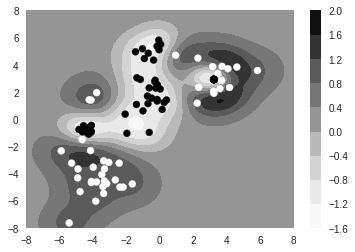

In [10]:
vdecision = np.vectorize(decision,excluded=[2])
x1list = np.linspace(-8.0,8.0,100)
x2list = np.linspace(-8.0,8.0,100)
X1, X2 = np.meshgrid(x1list,x2list)
Z = vdecision(X1,X2,clf)
cp = plt.contourf(X1,X2,Z)
plt.colorbar(cp)
plt.scatter(X[:,0],X[:,1],c=Y,cmap='gray')
plt.show()

# 3. Deep Learning

In [13]:
%matplotlib inline
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from google.colab import files

stuff = files.upload()

Saving images.npy to images.npy
Saving utils.py to utils.py


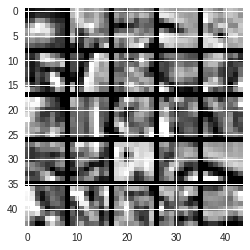

In [14]:
from scipy.optimize import fmin_l_bfgs_b as minimize
from utils import normalize, tile_raster_images, sigmoid
from utils import ravelParameters, unravelParameters
from utils import initializeParameters
from utils import computeNumericalGradient
nV = 8*8 # number of visible units
nH = 25 # number of hidden units
dW = 0.0001 # weight decay term
sW = 3 # sparsity penalty term
npy = 'images.npy'
X = normalize(np.load(npy))
plt.imshow(tile_raster_images(X=X,
img_shape=(8,8),tile_shape=(5,5),
tile_spacing=(1,1)),cmap='gray')
plt.show()

**3a.**

In [18]:
def sparseAutoencoderCost(theta,nV,nH,dW,sW,X):
  W1,W2,b1,b2 = unravelParameters(theta,nH,nV)
  n = X.shape[0]
  z2 = np.add(np.matmul(X, W1), np.matmul(np.ones((n,1)), b1.T))
  a2 = sigmoid(z2)

  z3 = np.add(np.matmul(a2, W2), np.matmul(np.ones((n,1)), b2.T))
  a3 = sigmoid(z3)
  eps = a3-X
  loss = np.sum(eps**2)/(2*n)
  decay = (np.sum(W1**2) + np.sum(W2**2))/2

  # Compute sparsity terms and total cost
  rho = 0.01
  a2mean = np.mean(a2,axis=0).reshape(nH,1)
  kl = np.sum(rho*np.log(rho/a2mean)+\
  (1-rho)*np.log((1-rho)/(1-a2mean)))
  dkl = -rho/a2mean+(1-rho)/(1-a2mean)
  cost = loss+dW*decay+sW*kl
  d3 = eps*a3*(1-a3)
  d2 = (sW*dkl.T+np.dot(d3,W2.T))*a2*(1-a2)
  W1grad = np.add(np.matmul(X.T, d2)/n, dW*W1)
  W2grad = np.add(np.matmul(a2.T, d3)/n, dW*W2)
  b1grad = np.matmul(d2.T, np.ones((n, 1)))/n
  b2grad = np.matmul(d3.T, np.ones((n, 1)))/n

  grad = ravelParameters(W1grad,W2grad,b1grad,b2grad)
  print(' .',end="")
  return cost,grad

theta = initializeParameters(nH,nV)
cost,grad = sparseAutoencoderCost(theta,nV,nH,dW,sW,X)

 .

**3b.**

In [19]:
print('\nComparing numerical gradient with backprop gradient')
num_coords = 5
indices = np.random.choice(theta.size,num_coords,replace=False)
numgrad = computeNumericalGradient(lambda t: sparseAutoencoderCost(t,nV,nH,dW,sW,X)[0],theta,indices)
subnumgrad = numgrad[indices]
subgrad = grad[indices]
diff = norm(subnumgrad-subgrad)/norm(subnumgrad+subgrad)
print('\n',np.array([subnumgrad,subgrad]).T)
print('The relative difference is',diff)


Comparing numerical gradient with backprop gradient
 . . . . . . . . . .
 [[1.19109963e-02 1.19109963e-02]
 [1.32910348e-02 1.32910347e-02]
 [7.08213563e-01 7.08213563e-01]
 [1.07416577e+00 1.07416577e+00]
 [3.10076587e-04 3.10076565e-04]]
The relative difference is 9.372086045356316e-11


**3c.**


Training neural network
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

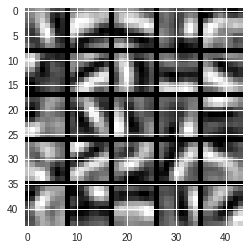

In [17]:
print('\nTraining neural network')
theta = initializeParameters(nH,nV)
opttheta,cost,messages = minimize(sparseAutoencoderCost,
theta,fprime=None,maxiter=400,args=(nV,nH,dW,sW,X))
W1,W2,b1,b2 = unravelParameters(opttheta,nH,nV)
plt.imshow(tile_raster_images(X=W1.T,
img_shape=(8,8),tile_shape=(5,5),
tile_spacing=(1,1)),cmap='gray')
plt.show()

# 4. Proof of Two Equations

![4a](https://github.com/charleswongzx/machine-learning-01.112/blob/master/HW3/photo6240041496711637048.jpg?raw=true)

It does matter. While the frequency is normalised, the frequency of occurrence of a word n in both corpuses is different and will affect θ^w.

![4b](https://github.com/charleswongzx/machine-learning-01.112/blob/master/HW3/photo6240238536926275608.jpg?raw=true)